# Содержание
1. [Открытие данных](#start)
2. [Подготовка данных](#prepare)
3. [Анализ данных](#Analysis)
4. [Проверка гипотез ](#checking)
5. [Вывод](#conclusion)

<b> Определение перспективного тарифа для телеком-компании </b>

 Клиентам компании «Мегалайн» — федерального оператора сотовой связи, предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. Имеются данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

<b>Описание тарифов</b>

<b>Тариф «Смарт»</b> <br>
Ежемесячная плата: 550 рублей<br>
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика<br>
Стоимость услуг сверх тарифного пакета:<br>
- минута разговора: 3 рубля<br>
- сообщение: 3 рубля<br>
- 1 Гб интернет-трафика: 200 рублей<br>

<b>Тариф «Ультра»</b><br>
Ежемесячная плата: 1950 рублей<br>
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика<br>
Стоимость услуг сверх тарифного пакета:<br>
 - минута разговора: 1 рубль<br>
 - сообщение: 1 рубль<br>
 - 1 Гб интернет-трафика: 150 рублей<br>

<a id="start"></a>
### Открытие данных

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Чтенение файлов
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

<a id="prepare"></a>
### Подготовка данных

In [3]:
# Посмотрим на данные
for data in [calls, internet, messages, tariffs, users]: 
    print(data.head())
    print('---------------------------------------------')

       id   call_date  duration  user_id
0  1000_0  2018-07-25      0.00     1000
1  1000_1  2018-08-17      0.00     1000
2  1000_2  2018-06-11      2.85     1000
3  1000_3  2018-09-21     13.80     1000
4  1000_4  2018-12-15      5.18     1000
---------------------------------------------
   Unnamed: 0      id  mb_used session_date  user_id
0           0  1000_0   112.95   2018-11-25     1000
1           1  1000_1  1052.81   2018-09-07     1000
2           2  1000_2  1197.26   2018-06-25     1000
3           3  1000_3   550.27   2018-08-22     1000
4           4  1000_4   302.56   2018-09-24     1000
---------------------------------------------
       id message_date  user_id
0  1000_0   2018-06-27     1000
1  1000_1   2018-10-08     1000
2  1000_2   2018-08-04     1000
3  1000_3   2018-06-16     1000
4  1000_4   2018-12-05     1000
---------------------------------------------
   messages_included  mb_per_month_included  minutes_included  \
0                 50                  153

In [4]:
# Посмотрим, что представляют из себя данные
for data in [calls, internet, messages, tariffs, users]: 
    print(data.info())
    print('---------------------------------------------')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None
---------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None
---------------------------------------------


Видим, что есть пропуски в таблице users в столбце churn_date, что показывает, что тариф для пользователя еще действовал на момент выгрузки. Также видим, что не корректно указан тип данных времени. 

In [5]:
# Изменим тип данных.
calls['call_date'] = pd.to_datetime(calls['call_date'])
internet['session_date'] = pd.to_datetime(internet['session_date'])
messages['message_date'] = pd.to_datetime(messages['message_date'])
users['churn_date'] = pd.to_datetime(users['churn_date'])
users['reg_date'] = pd.to_datetime(users['reg_date'])

In [6]:
# Пропуски в столюце Сhurn_date заменим нулями.
users['churn_date'] = users['churn_date'].fillna(0)

In [7]:
# Округлим длительность звонков, согласно условию.
calls['duration'] = np.ceil(calls['duration']).astype(int)
calls

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000
...,...,...,...,...
202602,1499_215,2018-12-26,1,1499
202603,1499_216,2018-10-18,19,1499
202604,1499_217,2018-11-10,11,1499
202605,1499_218,2018-10-06,5,1499


In [8]:
# Округлим объем потраченного трафика в большую сторону.
#internet['mb_used'] = np.ceil(internet['mb_used']).astype(int) 
#internet

Были изменены типы данных времени на datetime. В таблице users пропуски заменены нулями. В таблице calls и internet значения округлены до целого вверх значений.

#### Количество сделанных звонков и израсходованных минут разговора по месяцам;

In [9]:
# Выделим месяц в отдельный столбец
calls['month'] = calls['call_date'].dt.month

In [10]:
# Создадим сводную таблицу по звонкам.
calls_table = calls.pivot_table(index= ['month', 'user_id'], values = ['duration'], aggfunc = ['count','sum'])
calls_table.columns = ['count_calls', 'duration']
calls_table = calls_table.reset_index()
calls_table

,month,user_id,count_calls,duration
0,1,1005,15,95
1,1,1032,61,380
2,1,1045,1,9
3,1,1055,64,551
4,1,1071,24,194
...,...,...,...,...
3169,12,1494,62,418
3170,12,1495,155,1031
3171,12,1496,80,518
3172,12,1497,71,545


#### Количество отправленных сообщений по месяцам;

In [11]:
# Выделим месяц в отдельный столбец
messages['month'] = messages['message_date'].dt.month

In [12]:
# Создадим сводную таблицу по сообщениям.
messages_table = messages.pivot_table(index = ['month', 'user_id'], values = ['message_date'], aggfunc = 'count')
messages_table.columns=['count_message']
messages_table= messages_table.reset_index()
messages_table

,month,user_id,count_message
0,1,1005,7
1,1,1032,38
2,1,1045,5
3,1,1055,30
4,1,1071,16
...,...,...,...
2712,12,1493,78
2713,12,1495,84
2714,12,1496,51
2715,12,1497,17


#### Объем израсходованного интернет-трафика по месяцам;

In [13]:
#internet['mb_used'] = np.ceil(internet['mb_used']).astype(int)
#internet.head()

In [14]:
# Выделим месяц в отдельный столбец
internet['month'] = internet['session_date'].dt.month

In [15]:
# Создадим сводную таблицу по интернет трафику.
internet_table = internet.pivot_table(index =['month', 'user_id'], values = 'mb_used', aggfunc = 'sum').reset_index()
internet_table['mb_used'] = np.ceil(internet_table['mb_used']/1024).astype(int)
internet_table.columns=['month','user_id','gb_used']
internet_table

,month,user_id,gb_used
0,1,1005,3
1,1,1032,24
2,1,1045,3
3,1,1055,17
4,1,1071,16
...,...,...,...
3198,12,1494,18
3199,12,1495,23
3200,12,1496,21
3201,12,1497,20


In [16]:
# Объединим полученные сводные таблицы и таблицу пользователей в одну, чтобы сравнить полученные значения.
#table_all = users[['user_id', 'tariff']].merge(calls_table, on = 'user_id', how='left').\
#merge(messages_table[['user_id','count_message']], on = 'user_id', how='outer') \
#.merge(internet_table[['user_id','gb_used']], on = 'user_id',how='outer')
#table_all

In [17]:
table_all = calls_table.merge(messages_table, on = ['user_id','month'], how='outer')
table_all = table_all.merge(internet_table, on = ['user_id','month'],how='outer')
table_all = table_all.merge(users[['user_id', 'tariff','city']], on = 'user_id', how='outer')
table_all

,month,user_id,count_calls,duration,count_message,gb_used,tariff,city
0,1.0,1005,15.0,95.0,7.0,3.0,smart,Набережные Челны
1,2.0,1005,69.0,456.0,38.0,8.0,smart,Набережные Челны
2,3.0,1005,77.0,606.0,56.0,11.0,smart,Набережные Челны
3,4.0,1005,101.0,712.0,41.0,10.0,smart,Набережные Челны
4,5.0,1005,73.0,595.0,42.0,8.0,smart,Набережные Челны
...,...,...,...,...,...,...,...,...
3211,10.0,1328,NaN,NaN,6.0,22.0,ultra,Мурманск
3212,11.0,1328,NaN,NaN,8.0,35.0,ultra,Мурманск
3213,12.0,1328,NaN,NaN,7.0,39.0,ultra,Мурманск
3214,NaN,1128,NaN,NaN,NaN,NaN,ultra,Волжский


In [18]:
table_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month          3214 non-null   float64
 1   user_id        3216 non-null   int64  
 2   count_calls    3174 non-null   float64
 3   duration       3174 non-null   float64
 4   count_message  2717 non-null   float64
 5   gb_used        3203 non-null   float64
 6   tariff         3216 non-null   object 
 7   city           3216 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 226.1+ KB


Применив метод Info() к таблице table_all видим пустые значения в столбцах month, count_calls, duration и count_message. Заменим их на нули.  

In [19]:
# Комментарий ревьюера
table_all.user_id.unique().shape 

(500,)

In [20]:
# Заменим нулямипустые значения
table_all = table_all.fillna(0)
table_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month          3216 non-null   float64
 1   user_id        3216 non-null   int64  
 2   count_calls    3216 non-null   float64
 3   duration       3216 non-null   float64
 4   count_message  3216 non-null   float64
 5   gb_used        3216 non-null   float64
 6   tariff         3216 non-null   object 
 7   city           3216 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 226.1+ KB


In [21]:
# Оставим в таблице значение без нулевого месяца, чтобы не исказаить данные.
table_all = table_all[table_all['month'] !=0]   
table_all

,month,user_id,count_calls,duration,count_message,gb_used,tariff,city
0,1.0,1005,15.0,95.0,7.0,3.0,smart,Набережные Челны
1,2.0,1005,69.0,456.0,38.0,8.0,smart,Набережные Челны
2,3.0,1005,77.0,606.0,56.0,11.0,smart,Набережные Челны
3,4.0,1005,101.0,712.0,41.0,10.0,smart,Набережные Челны
4,5.0,1005,73.0,595.0,42.0,8.0,smart,Набережные Челны
...,...,...,...,...,...,...,...,...
3209,11.0,1489,0.0,0.0,20.0,18.0,smart,Санкт-Петербург
3210,12.0,1489,0.0,0.0,35.0,17.0,smart,Санкт-Петербург
3211,10.0,1328,0.0,0.0,6.0,22.0,ultra,Мурманск
3212,11.0,1328,0.0,0.0,8.0,35.0,ultra,Мурманск


Уберем из таблицы данные со значением месяца 0, т.к. у этих записей количество минут, сообщений и мб также равно 0, они внесут нам искажения в распределения.

In [22]:
# Комментарий ревьюера
table_all.user_id.unique().shape 

(498,)

#### Помесячная выручка с каждого пользователя.

In [23]:
# Создадим функцию для подсчета выручки с каждого пользователя 
def get_revenue(row):
    calls = row['count_calls']
    messages = row['count_message']
    duration = row['duration']
    gb_used = row['gb_used']
    tariff = row['tariff']
    
    gig =1024
    
    if tariff == 'smart':
        final_duration = duration - tariffs.loc[0, 'minutes_included']
        final_messages = messages - tariffs.loc[0, 'messages_included']
        final_gb = gb_used - tariffs.loc[0, 'mb_per_month_included']/1024
       
        
        if final_duration < 0:
            final_duration = 0
        if final_messages < 0: 
            final_messages = 0   
        if final_gb < 0:
            final_gb = 0
      
        
        return (tariffs.loc[0, 'rub_per_message'] * final_messages + tariffs.loc[0, 'rub_per_gb'] * final_gb + 
                   tariffs.loc[0, 'rub_per_minute'] * final_duration + tariffs.loc[0, 'rub_monthly_fee']) 
    
    else:
        final_duration = duration - tariffs.loc[1, 'minutes_included']
        final_messages = messages - tariffs.loc[1, 'messages_included']
        final_gb = gb_used - tariffs.loc[1, 'mb_per_month_included']/1024
                
        if final_duration < 0: 
            final_duration = 0
        if final_messages < 0: 
            final_messages = 0    
        if final_gb < 0: 
            final_gb = 0
        
        
        return (tariffs.loc[1, 'rub_per_message'] * final_messages + (tariffs.loc[1, 'rub_per_gb']) * final_gb + 
                   tariffs.loc[1, 'rub_per_minute'] * final_duration + tariffs.loc[1, 'rub_monthly_fee'])

table_all['revenue'] = table_all.apply(get_revenue, axis=1)
table_all.head(10)

,month,user_id,count_calls,duration,count_message,gb_used,tariff,city,revenue
0,1.0,1005,15.0,95.0,7.0,3.0,smart,Набережные Челны,550.0
1,2.0,1005,69.0,456.0,38.0,8.0,smart,Набережные Челны,550.0
2,3.0,1005,77.0,606.0,56.0,11.0,smart,Набережные Челны,886.0
3,4.0,1005,101.0,712.0,41.0,10.0,smart,Набережные Челны,1186.0
4,5.0,1005,73.0,595.0,42.0,8.0,smart,Набережные Челны,835.0
5,6.0,1005,80.0,612.0,47.0,10.0,smart,Набережные Челны,886.0
6,7.0,1005,77.0,569.0,56.0,8.0,smart,Набережные Челны,775.0
7,8.0,1005,71.0,619.0,64.0,8.0,smart,Набережные Челны,949.0
8,9.0,1005,66.0,479.0,52.0,7.0,smart,Набережные Челны,556.0
9,10.0,1005,100.0,723.0,44.0,8.0,smart,Набережные Челны,1219.0


In [24]:
# Комментарий ревьюера
table_all.revenue.unique()

array([ 550.,  886., 1186.,  835.,  775.,  949.,  556., 1219.,  694.,
        838., 2350., 2550., 1013.,  986., 1350., 1550., 1171., 2150.,
       1150.,  574., 1356., 1965.,  995.,  971., 2189.,  756., 2213.,
       1103.,  924.,  750., 2004.,  950., 1750., 2441., 1950.,  679.,
       1040., 1805.,  974.,  934., 1126., 1012.,  964.,  733., 1069.,
       1180., 2400., 1571.,  604., 1404.,  751., 1079.,  586.,  963.,
       1038.,  792., 1342., 1612., 1655.,  765.,  577.,  912., 2250.,
       2850., 1565.,  777., 2100., 2601., 1554., 1489., 1576., 1095.,
       1137., 2903., 1715., 1138.,  703.,  676., 2950., 2022., 1804.,
       1974., 1856., 2643., 2095., 1288., 2893., 2952., 2510., 2944.,
       1494., 1647., 2907., 1500., 2164., 1312., 1051., 1336., 1487.,
       2609., 1825., 1330., 1816.,  571., 2592.,  810.,  589.,  631.,
        831., 1440., 1631., 1646.,  619.,  862., 1455.,  867.,  730.,
        691., 2165., 3550., 1168., 1365., 2365.,  766.,  637.,  601.,
        739., 3000.,

<a id="Analysis"></a>
### Анализ данных

In [27]:
# Рассчитаем медиану, дисперсию и стандартное отклонение:
stat_param = table_all.pivot_table(index=['tariff'], values=['duration', 'gb_used', 'count_message'], 
                    aggfunc={'duration': [np.median, np.var, np.std], 
                             'gb_used': [np.median, np.var, np.std], 
                             'count_message': [np.median, np.var, np.std]})
stat_param

count_message                         duration              \
              median        std          var   median         std   
tariff                                                              
smart           28.0  28.227876   796.812958    422.0  190.313730   
ultra           38.0  47.804457  2285.266143    518.0  317.606098   

                      gb_used                       
                  var  median       std        var  
tariff                                              
smart    36219.315784    17.0  5.747061  33.028705  
ultra   100873.633397    19.0  9.853511  97.091686

По данным из таблицы видно, тариф "Ультра" имеет большую дисперсию для минут, сообщений и объема потраченного интернет-трафика, чем тариф "Смарт". 

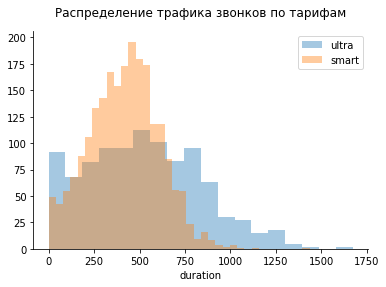

In [28]:
# Построим гистрограмму распределения тарфика звонков по тарифам.
for tariff in ['ultra', 'smart']:
    ax = sns.distplot(table_all.query('tariff == @tariff')['duration'], kde=False, label=tariff)
    ax.set_title('Распределение трафика звонков по тарифам', fontdict={'fontsize':12}, pad=15)
    sns.despine()
    _ = plt.legend(['ultra', 'smart'])

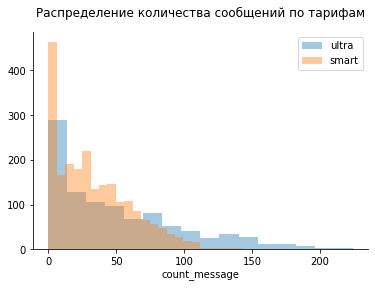

In [29]:
# Построим гистрограмму распределения сообщений по тарифам.
for tariff in ['ultra', 'smart']:
    ax = sns.distplot(table_all.query('tariff == @tariff')['count_message'], kde=False, label=tariff)
    ax.set_title('Распределение количества сообщений по тарифам', fontdict={'fontsize':12}, pad=15)
    sns.despine()
    _ = plt.legend(['ultra', 'smart'])

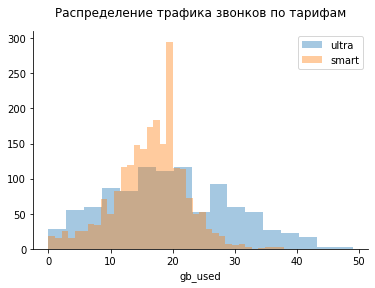

In [30]:
# Построим гистрограмму распределения минут по тарифам.
for tariff in ['ultra', 'smart']:
    ax = sns.distplot(table_all.query('tariff == @tariff')['gb_used'], kde=False)
    ax.set_title('Распределение трафика звонков по тарифам', fontdict={'fontsize':12}, pad=15)
    sns.despine()
    _ = plt.legend(['ultra', 'smart'])

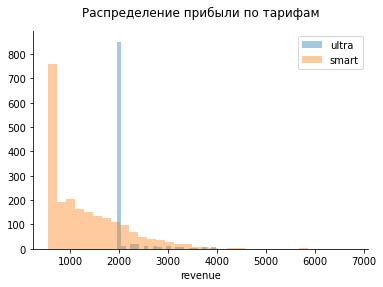

In [31]:
# Построим гистрограмму распределения затрат пользователей по тарифам.
for tariff in ['ultra', 'smart']:
    ax = sns.distplot(table_all.query('tariff == @tariff')['revenue'], kde=False)
    ax.set_title('Распределение прибыли по тарифам', fontdict={'fontsize':12}, pad=15)
    sns.despine()
    _ = plt.legend(['ultra', 'smart'])

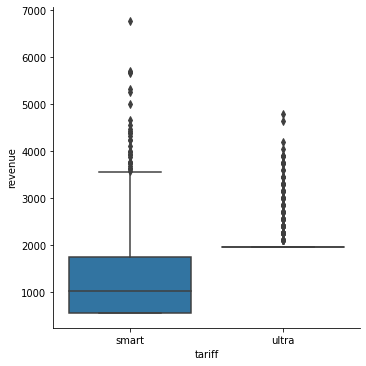

In [32]:
 sns.catplot(x="tariff", y="revenue", kind="box", data=table_all, orient='v')

По гистограмме и диаграмме размаха видно, что в среднем больше прибыли приносит тариф "Ультра".

По гистрограмме по доходам видно, что пользователи тарифа "Ультра" в основном не выходят за пределы своего тарифа. Тогда как пользователи тарифа "Смарт" докупают услуги в течение месяца.

По гистограммам видно, что дисперсия тарифа "Смарта" меньше, чем у пользователей с тарифом "Ультра" по всем показателям: по длительности разговора, числу сообщений и использованному интернет-трафику. 

<a id="checking"></a>
### Проверка гипотез 

#### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

Сформируем H0 - средняя выручка пользователей тарифов «Ультра» и «Смарт» равна.
H1 - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.
Для проверки гипотезы используем scipy.stats.ttest_ind, так как имеем две независимые генеральные совокупности.

In [33]:
# Проверим гипотезу

ultra = table_all.query('tariff == "ultra"')['revenue']
smart = table_all.query('tariff == "smart"')['revenue']

alpha = .05

results = st.ttest_ind(ultra, smart, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.2606313931076085e-250
Отвергаем нулевую гипотезу


In [34]:
ultra_median = round(table_all.query('tariff == "ultra"')['revenue'].mean())
smart_median = round(table_all.query('tariff == "smart"')['revenue'].mean())
print('Средняя выручка тарифа "Ультра" равна', ultra_median)
print('Средняя выручка тарифа "Смарт" равна', smart_median)

Средняя выручка тарифа "Ультра" равна 2070
Средняя выручка тарифа "Смарт" равна 1290


Рассчитав средние выручки по тарифам видно, что выручки не равны, значит вывод, полученный при проверке гипотезы, коректен.

Как проверка гипотезы, так и расчет средних значений говорят о том, что средняя выручка по тарифам не равна. Значит мы и правда можем отвергнуть нулевую гипотезу.

#### Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Сформируем H0 - средняя выручка пользователей из Москвы и пользователей из других регионов равна.
H1 - средняя выручка пользователей из Москвы и пользователей из других регионов различны.
Для проверки гипотезы используем scipy.stats.ttest_ind, т.к. имеем две независимые генеральные совокупности.

In [35]:
moscow = table_all.query('city == "Москва"')['revenue']
regions = table_all.query('city != "Москва"')['revenue']

alpha = .05

results = st.ttest_ind(moscow, regions, equal_var=False)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


In [36]:
moscow = round(table_all.query('city == "Москва"')['revenue'].mean())
regions = round(table_all.query('city != "Москва"')['revenue'].mean())
print('Средняя выручка пользователей по Москве равна', moscow)
print('Средняя выручка пользователей из других регионов равна', regions)

Средняя выручка пользователей по Москве равна 1547
Средняя выручка пользователей из других регионов равна 1525


Проверка гипотезы показала, что отвергнуть нулевую гипотезу мы не можем. Так же при расчете средних мы приходим к выводу, что прибыль оператору сотовой связи пользователи Москвы и регионов приносят в среднем близкую друг к другу.

<a id="conclusion"></a>
### Вывод 

Из анализа доходов по тарифам видно, что доход от тарифа «Ультра» больше, чем доход от тарифа «Смарт». От одного пользователя в месяц получает 2070 рублей (тариф "Ультра") и 1290 рублей (тариф "Смарт"). Получается, что пользователи тарифа "Ультра" меньше докупают услуги вне тарифа, чем пользователи тарифа "Смарт".  

Так же с помощью проверки гипотезы о равенстве прибыли от пользователей Москвы и других городов, а также проверки средней прибыли по регионам и Москве, пришли к выводу, что отвергать гипотезу не получается, потому что средняя прибыль не сильно различаемся между собой, в Москве 1547, в других городах 1525

Text(0, 0.5, 'Рубли')

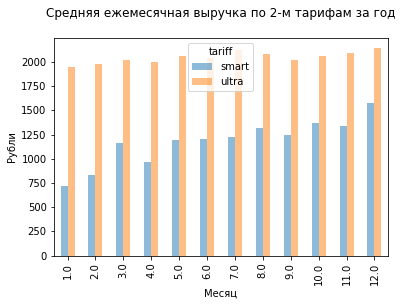

In [37]:
# Комментарий ревьюера 3
table_all.pivot_table(index='tariff', columns='month', values='revenue', aggfunc='mean').T.plot(kind='bar', alpha=0.5)
plt.title('Средняя ежемесячная выручка по 2-м тарифам за год'+ "\n")
plt.xlabel('Месяц')
plt.ylabel('Рубли')